In [1]:
# importing Neccessary Library and constant variable

# !pip install tf_clahe
# !pip install -U scikit-learn
# !pip install matplotlib
# !pip install pandas

In [2]:
import itertools
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_io as tfio

import tf_clahe

import numpy as np
import pandas as pd 

from glob import glob
from tqdm import tqdm
from packaging import version
import os
from packaging import version
from datetime import datetime
# Import writer class from csv module
from csv import DictWriter

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

IMG_H = 128
IMG_W = 128
IMG_C = 3  ## Change this to 1 for grayscale.

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

# Weight initializers for the Generator network
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
AUTOTUNE = tf.data.AUTOTUNE

TensorFlow version:  2.6.2


In [3]:
# class for SSIM loss function
class SSIMLoss(tf.keras.losses.Loss):
    def __init__(self,
         reduction=tf.keras.losses.Reduction.AUTO,
         name='SSIMLoss'):
        super().__init__(reduction=reduction, name=name)

    def call(self, ori, recon):
        recon = tf.convert_to_tensor(recon)
        ori = tf.cast(ori, recon.dtype)

        # Loss 3: SSIM Loss
#         loss_ssim =  tf.reduce_mean(1 - tf.image.ssim(ori, recon, max_val=1.0)[0]) 
        loss_ssim = tf.reduce_mean(1 - tf.image.ssim(ori, recon, 2.0))
        return loss_ssim
    
# class for Feature loss function
class FeatureLoss(tf.keras.losses.Loss):
    def __init__(self,
             reduction=tf.keras.losses.Reduction.AUTO,
             name='FeatureLoss'):
        super().__init__(reduction=reduction, name=name)

    
    def call(self, real, fake):
        fake = tf.convert_to_tensor(fake)
        real = tf.cast(real, fake.dtype)
        # Loss 4: FEATURE Loss
        loss_feat = tf.reduce_mean(tf.pow((real-fake), 2))
        return loss_feat
    
# class for Adversarial loss function
class AdversarialLoss(tf.keras.losses.Loss):
    def __init__(self,
             reduction=tf.keras.losses.Reduction.AUTO,
             name='AdversarialLoss'):
        super().__init__(reduction=reduction, name=name)

    
    def call(self, logits_in, labels_in):
        labels_in = tf.convert_to_tensor(labels_in)
        logits_in = tf.cast(logits_in, labels_in.dtype)
        # Loss 4: FEATURE Loss
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))
        

In [4]:
# delcare all loss function that we will use

# for adversarial loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = AdversarialLoss()
# L1 Loss
mae = tf.keras.losses.MeanAbsoluteError()
# L2 Loss
mse = tf.keras.losses.MeanSquaredError() 
feat = FeatureLoss()

# SSIM loss
ssim = SSIMLoss()

In [5]:
'''
    Function for Balance Contrast Enhancement Technique (BCET)
    This technique provides solution to biased color (RGB) composition. 
    The contrast of the image can be stretched or compressed without changing the histogram pattern of the input image(x).
    The solution is based on the parabolic function obtained from the input image.
'''
@tf.function
def bcet(img):

    
    Lmin = tf.reduce_min(img) # MINIMUM OF INPUT IMAGE
#     Lmin = np.min(img) # MINIMUM OF INPUT IMAGE
#     print("Lmin", Lmin)
    Lmax = tf.reduce_max(img) # MAXIMUM OF INPUT IMAGE
#     Lmax = np.max(img) # MAXIMUM OF INPUT IMAGE
#     print("Lmax", Lmax)
    Lmean = tf.reduce_mean(img) #MEAN OF INPUT IMAGE
#     Lmean = np.mean(img) #MEAN OF INPUT IMAGE
#     print("Lmean", Lmean)
    LMssum = tf.reduce_mean(img * img) #MEAN SQUARE SUM OF INPUT IMAGE
#     LMssum = np.mean(pow(img, 2)) #MEAN SQUARE SUM OF INPUT IMAGE
#     print("LMssum", LMssum)

    Gmin = tf.constant(0, dtype="float32") #MINIMUM OF OUTPUT IMAGE
    Gmax = tf.constant(255, dtype="float32") #MAXIMUM OF OUTPUT IMAGE
    Gmean = tf.constant(110, dtype="float32") #MEAN OF OUTPUT IMAGE
    
    subber = tf.constant(2, dtype="float32")
    
    # find b
    
    bnum = ((Lmax**subber)*(Gmean-Gmin)) - (LMssum*(Gmax-Gmin)) + ((Lmin**subber) *(Gmax-Gmean))
    bden = subber * ((Lmax*(Gmean-Gmin)) - (Lmean*(Gmax-Gmin)) + (Lmin*(Gmax-Gmean)))
    
    b = bnum/bden
    
    # find a
    a1 = Gmax-Gmin
    a2 = Lmax-Lmin
    a3 = Lmax+Lmin-(subber*b)
            
    a = a1/(a2*a3)
    
    # find c
    c = Gmin - (a*(Lmin-b)**subber)
    
    # Process raster
    y = a*((img - b)**subber) + c #PARABOLIC FUNCTION

    return y

def bcet_processing(img,channels=3):
    img = tf.cast(img, tf.float32)
    layers = []
    for i in range(channels):
        layer = img[:,:,i]
        layer = bcet(layer)
        layers.append(layer)
        
    final_image = tf.stack(layers, axis=-1)

    return final_image

In [6]:
# function for  preprocessing data 
def prep_stage(x):
    ### implement clahe to images
    # x = tf_clahe.clahe(x)
    
    ### implement BCET to iamges
    # x = bcet_processing(x)
    
    ### custom 
    # x = tf.cast(x, tf.float32) / 255.0
   
    x = tfio.experimental.color.rgb_to_bgr(x)
    x = tf.image.adjust_contrast(x, 10.)
    x = tf.image.adjust_hue(x, 1.)
    x = tf.image.adjust_gamma(x)
    x = tfa.image.median_filter2d(x)
    # x = tf.cast(x * 255.0, tf.uint8)
    ### implement Histogram normalization to iamges
    # x = tfa.image.equalize(x)

    ### crop or pad images
    # x = tf.image.resize_with_crop_or_pad(x, IMG_H, IMG_W)
    x = tf.image.resize(x, (IMG_H, IMG_W))
    return x

def augment_dataset_batch_train(dataset_batch):

    flip_up_down = dataset_batch.map(lambda x: (tf.image.flip_up_down(x)), 
              num_parallel_calls=AUTOTUNE)
    
    flip_left_right = dataset_batch.map(lambda x: (tf.image.flip_left_right(x)), 
              num_parallel_calls=AUTOTUNE)
    
    dataset_batch = dataset_batch.concatenate(flip_up_down)
    dataset_batch = dataset_batch.concatenate(flip_left_right)
    
    
    return dataset_batch

def augment_dataset_batch_test(dataset_batch):
    AUTOTUNE = tf.data.AUTOTUNE
    
    
#     dataset_batch = dataset_batch.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    
#     dataset_batch = dataset_batch.map(lambda x, y: (tf.image.per_image_standardization(x), y), 
#               num_parallel_calls=AUTOTUNE)
    
    
    return dataset_batch

In [7]:
def read_data_with_labels(filepath, class_names):
    image_list = []
    label_list = []
    for class_n in class_names:  # do dogs and cats
        path = os.path.join(filepath,class_n)  # create path to dogs and cats
        class_num = class_names.index(class_n)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  
            if ".DS_Store" != img:
                filpath = os.path.join(path,img)
#                 print(filpath, class_num)
                image_list.append(filpath)
                label_list.append(class_num)
#     print(image_list, label_list)
    return image_list, label_list


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_bmp(img, channels=IMG_C)
    img = prep_stage(img)
    img = tf.cast(img, tf.float32)
#     rescailing image from 0,255 to -1,1
    img = (img - 127.5) / 127.5
    
    return img

def load_image_with_label(image_path, label):
    class_names = ["normal", "defect"]
#     print(image_path)
    img = tf.io.read_file(image_path)
    img = tf.io.decode_bmp(img, channels=IMG_C)
    img = prep_stage(img)
    img = tf.cast(img, tf.float32)
    #     rescailing image from 0,255 to -1,1
    img = (img - 127.5) / 127.5
    # img /= 255.0
    
    return img, label


def tf_dataset(images_path, batch_size, labels=False, class_names=None):
  
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


def tf_dataset_labels(images_path, batch_size, class_names=None):
    
    filenames, labels = read_data_with_labels(images_path, class_names)
#     print("testing")
#     print(filenames, labels)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image_with_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [8]:
# load image dataset for testing with labels
def load_image_test(filename, class_names, size=(IMG_H,IMG_W)):
	# load image with the preferred size
    pixels = tf_dataset_labels(images_path=filename, batch_size=1, class_names=class_names)
    pixels = augment_dataset_batch_test(pixels)
    
    return pixels

# load image dataset for trainnig without labels
def load_image_train(filename, batch_size):
	# load image with the preferred size
    
    pixels = tf_dataset(filename, batch_size)
    
    pixels = augment_dataset_batch_train(pixels)

    return pixels

In [9]:
def plot_roc_curve(fpr, tpr, name_model):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig(name_model+'_roc_curve.png')
    plt.show()
    plt.clf()
    


''' calculate the auc value for lables and scores'''
def roc(labels, scores, name_model):
    """Compute ROC curve and ROC area for each class"""
    roc_auc = dict()
    # True/False Positive Rates.
    fpr, tpr, threshold = roc_curve(labels, scores)
    print("threshold: ", threshold)
    roc_auc = auc(fpr, tpr)
    # get a threshod that perform very well.
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    # draw plot for ROC-Curve
    plot_roc_curve(fpr, tpr, name_model)
    
    return roc_auc, optimal_threshold

def plot_loss_with_rlabel(x_value, y_value, real_label, name_model, prefix, label_axis=["x_label", "y_label"]):
    # 'bo-' means blue color, round points, solid lines
    colours = ["blue" if x == 1.0 else "red" for x in real_label]
    plt.scatter(x_value, y_value, label='loss_value',c = colours)
#     plt.rcParams["figure.figsize"] = (50,3)
    # Set a title of the current axes.
    plt.title(prefix + "_" + name_model)
    # show a legend on the plot
    red_patch = mpatches.Patch(color='red', label='Normal Display')
    blue_patch = mpatches.Patch(color='blue', label='Defect Display')
    plt.legend(handles=[red_patch, blue_patch])
    # Display a figure.
    plt.xlabel(label_axis[0])
    plt.ylabel(label_axis[1])
    
    plt.savefig(name_model + "_" + prefix +'_rec_feat_rlabel.png')
    plt.show()
    plt.clf()

In [10]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title+'_cm.png')
    plt.show()
    plt.clf()

In [11]:
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3), padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (3, 3), strides=2, padding="same")(input)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [12]:
# create generator model based on resnet50 and unet network
def build_generator_resnet50_unet(input_shape):
    # print(inputs)
    # print("pretained start")
    """ Pre-trained ResNet50 Model """
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=input_shape)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (256 x 256)
    s2 = resnet50.get_layer("conv1_relu").output        ## (128 x 128)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (64 x 64)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (32 x 32)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (16 x 16)

    """ Decoder """
    x = IMG_H
    d1 = decoder_block(b1, s4, x)                     ## (32 x 32)
    x = x/2
    d2 = decoder_block(d1, s3, x)                     ## (64 x 64)
    x = x/2
    d3 = decoder_block(d2, s2, x)                     ## (128 x 128)
    x = x/2
    d4 = decoder_block(d3, s1, x)                      ## (256 x 256)
    
    """ Output """
#     outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="sigmoid")(d4)
    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="tanh")(d4)
#     outputs = tf.keras.layers.Conv2D(3, 1, padding="same")(d5)

    model = tf.keras.models.Model(inputs, outputs)

    return model

In [13]:
# create discriminator model
def build_discriminator(inputs):
    f = [2**i for i in range(4)]
    x = inputs
    for i in range(0, 4):
        x = tf.keras.layers.SeparableConvolution2D(f[i] * IMG_H ,kernel_size= (3, 3), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    
    feature = x
    
    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(1, activation="tanh")(x)
#     output = tf.keras.layers.Dense(1, activation="tanh")(x)
#     output = tf.keras.layers.Dense(1)(x)
    
    
    model = tf.keras.models.Model(inputs, outputs = [feature, output])
    
    return model
    # return x

In [14]:
class ResUnetGAN(tf.keras.models.Model):
    def __init__(self, generator, discriminator):
        super(ResUnetGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
       
        # Regularization Rate for each loss function
        self.ADV_REG_RATE_LF = 1
        self.REC_REG_RATE_LF = 50
        self.SSIM_REG_RATE_LF = 10
        self.FEAT_REG_RATE_LF = 1
        self.field_names = ['epoch', 'gen_loss', 'disc_loss']
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6, beta_1=0.5, beta_2=0.999)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6, beta_1=0.5, beta_2=0.999)
    
    
    def compile(self, g_optimizer, d_optimizer, filepath, resume=False):
        super(ResUnetGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
#         columns name (epoch, gen_loss, disc_loss)
        
        
        logs = pd.DataFrame([], columns=self.field_names)

        if not resume:
            logs.to_csv(filepath, encoding='utf-8', index=False)
        else:
            fileExist = os.path.exists(filepath)
            if not fileExist:
                print("file not found. then we create new file")
                logs.to_csv(filepath, encoding='utf-8', index=False)
            

            
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
    @tf.function
    def train_step(self, images):

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # tf.print("Images: ", images)
            reconstructed_images = self.generator(images, training=True)
            feature_real, label_real = self.discriminator(images, training=True)
            # print(generated_images.shape)
            feature_fake, label_fake = self.discriminator(reconstructed_images, training=True)

            # Loss 1: ADVERSARIAL loss
            real_loss = cross_entropy(label_real, tf.ones_like(label_real))
            fake_loss = cross_entropy(label_fake, tf.zeros_like(label_fake))
            adv_loss = real_loss + fake_loss
            
#             gen_adv_loss = cross_entropy(fake_output, tf.ones_like(fake_output))
            
            # Loss 2: RECONSTRUCTION loss (L1)
            loss_rec = tf.reduce_mean(mae(images, reconstructed_images))
        
            # Loss 3: SSIM Loss
            loss_ssim =  ssim(images, reconstructed_images)
        
            # Loss 4: FEATURE Loss
#             loss_feat = tf.reduce_mean(mse(real_output, fake_output))
            loss_feat = feat(feature_real, feature_fake)

            gen_loss = tf.reduce_mean( (adv_loss * self.ADV_REG_RATE_LF) + (loss_rec * self.REC_REG_RATE_LF) + (loss_ssim * self.SSIM_REG_RATE_LF) + (loss_feat * self.FEAT_REG_RATE_LF) )
            disc_loss = tf.reduce_mean( (adv_loss * self.ADV_REG_RATE_LF) + (loss_feat * self.FEAT_REG_RATE_LF) )
#             disc_loss = adv_loss

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        

        
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        


        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
            "adv_loss": adv_loss,
#             "gen_adv_loss": gen_adv_loss,
            "loss_rec": loss_rec,
            "loss_ssim": loss_ssim,
            "loss_feat": loss_feat
        }

    def saved_model(self, gmodelpath, dmodelpath):
        self.generator.save(gmodelpath)
        self.discriminator.save(dmodelpath)

    def loaded_model(self, g_filepath, d_filepath):
        self.generator.load_weights(g_filepath)
        self.discriminator.load_weights(d_filepath)
        
    # load and save data of training process
    def load_save_processing(self,filepath, epoch_num, disc_loss, gen_loss, g_filepath, d_filepath, resume=False):
        # columns name (epoch, gen_loss, disc_loss)

        if resume:
            # load logs data
            logs = pd.read_csv(filepath)
            logs.sort_values("epoch", ascending=False)
            epoch = max(logs['epoch'].tolist(), default=0)
            
            epoch_list = logs['epoch'].tolist()
            disc_loss = logs['disc_loss'].tolist()
            gen_loss = logs['gen_loss'].tolist()
            
            
            # load model data
            self.loaded_model(g_filepath, d_filepath)
            print(epoch, disc_loss, gen_loss)
            return epoch, epoch_list, disc_loss, gen_loss
        
        else:
            data={'epoch':epoch_num,'disc_loss':disc_loss,'gen_loss':gen_loss}
            print("row added." , data)
            f_object = open(filepath, "a+")
            dwriter = DictWriter(f_object, fieldnames=self.field_names)
            dwriter.writerow(data)
            f_object.close()
            return None, None, None, None
            
            
    def testing(self, filepath, g_filepath, d_filepath, name_model):
#         threshold = 0.7
        class_names = ["normal", "defect"] # normal = 0, defect = 1
        test_dateset = load_image_test(filepath, class_names)
        # print(test_dateset)
        
        # range between 0-1
        anomaly_weight = 0.1
        
        scores_ano = []
        real_label = []
        rec_loss_list = []
        feat_loss_list = []
        ssim_loss_list = []
        i = 0
        self.generator.load_weights(g_filepath)
        self.discriminator.load_weights(d_filepath)
        
        
        for images, labels in test_dateset:
            i += 1
            
            reconstructed_images = self.generator(images, training=False)
            feature_real, label_real  = self.discriminator(images, training=False)
            # print(generated_images.shape)
            feature_fake, label_fake = self.discriminator(reconstructed_images, training=False)

            
            # Loss 2: RECONSTRUCTION loss (L1)
            loss_rec = tf.reduce_mean(mae(images, reconstructed_images))
        
        
            # loss_feat = tf.reduce_mean( tf.keras.losses.mse(real, fake) )
            loss_feat = feat(feature_real, feature_fake)

            # Loss 3: SSIM Loss
            loss_ssim =  ssim(images, reconstructed_images)
            
            score = (anomaly_weight * loss_rec) + ((1-anomaly_weight) * loss_feat)

#          
            scores_ano = np.append(scores_ano, score.numpy())
            real_label = np.append(real_label, labels.numpy()[0])
        
            rec_loss_list = np.append(rec_loss_list, loss_rec)
            feat_loss_list = np.append(feat_loss_list, loss_feat)
            ssim_loss_list = np.append(ssim_loss_list, loss_ssim)
        
#             print("reconstruction loss: ", loss_rec.numpy(), "feature losss: ", loss_feat.numpy(), "label: ", labels.numpy(), "score: ", score.numpy())
        
        
        ''' Scale scores vector between [0, 1]'''
        scores_ano = (scores_ano - scores_ano.min())/(scores_ano.max()-scores_ano.min())
        label_axis = ["feat_loss", "scores_anomaly"]
        plot_loss_with_rlabel(feat_loss_list, scores_ano, real_label, name_model, "feat_loss_x_scores_anomaly", label_axis)
#         print("scores_ano: ", scores_ano)
#         print("real_label: ", real_label)
#         scores_ano = (scores_ano > threshold).astype(int)
        auc_out, threshold = roc(real_label, scores_ano, name_model)
        print("auc: ", auc_out)
        print("threshold: ", threshold)
        
        
        
        scores_ano = (scores_ano > threshold).astype(int)
        cm = tf.math.confusion_matrix(labels=real_label, predictions=scores_ano).numpy()
        TP = cm[1][1]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[0][0]
        plot_confusion_matrix(cm, class_names, title=name_model)

        label_axis = ["ssim_loss", "scores_anomaly"]
        plot_loss_with_rlabel(ssim_loss_list, scores_ano, real_label, name_model, "ssim_loss_x_scores_anomaly", label_axis)
        
        diagonal_sum = cm.trace()
        sum_of_all_elements = cm.sum()

        print("Accuracy: ", diagonal_sum / sum_of_all_elements )
        print("False Alarm Rate: ", FP/(FP+TP))
        print("Leakage Rate: ", FN/(FN+TN))
        print("precision_score: ",precision_score(real_label, scores_ano))
#         print("recall_score: ", recall_score(real_label, scores_ano))
        print("recall_score: ", TP/(TP+FN))
#         F1 = 2 * (precision * recall) / (precision + recall)
        print("F1-Score: ", f1_score(real_label, scores_ano))
    
    
        
    def checking_gen_disc(self, mode, g_filepath, d_filepath, test_data_path):
        self.generator.load_weights(g_filepath)
        self.discriminator.load_weights(d_filepath)
#         path = "mura_data/RGB/test_data/normal/normal.bmp"
#         path = "mura_data/RGB/test_data/defect/defect.bmp"
#         path = "rgb_serius_defect/BUTTERFLY (2).bmp"
        paths = {
            "normal": test_data_path+"/normal/normal.bmp",
            "defect": test_data_path+"/defect/defect.bmp",
            "butterfly_defect": test_data_path+"/defect/BUTTERFLY (2).bmp",
            "water_defect": test_data_path+"/defect/0428-12 P20.bmp"
        }
   
        for i, v in paths.items():
            print(i,v)
            
            width=IMG_W
            height=IMG_H
            rows = 1
            cols = 3
            axes=[]
            fig = plt.figure()
            
            
            img = tf.io.read_file(v)
            img = tf.io.decode_bmp(img, channels=IMG_C)
            
            name_subplot = mode+'_original_'+i
            axes.append( fig.add_subplot(rows, cols, 1) )
            axes[-1].set_title('_original_')  
            plt.imshow(img.numpy().astype("int64"), alpha=1.0)
            plt.axis('off')
#             plt.savefig(name_original+'.png')
        
        
        
            img = prep_stage(img)
            img = tf.cast(img, tf.float64)

            name_subplot = mode+'_preprocessing_'+i
            axes.append( fig.add_subplot(rows, cols, 2) )
            axes[-1].set_title('_preprocessing_')  
            plt.imshow(img.numpy().astype("int64"), alpha=1.0)
            plt.axis('off')
            img = (img - 127.5) / 127.5
#             plt.savefig(mode+'_preprocessing_'+i+'.png')
   
        
            image = tf.reshape(img, (-1, IMG_H, IMG_W, IMG_C))
            reconstructed_images = self.generator.predict(image)
            reconstructed_images = tf.reshape(reconstructed_images, (IMG_H, IMG_W, IMG_C))
#             reconstructed_images = reconstructed_images[0, :, :, 0] * 127.5 + 127.5
#             reconstructed_images = reconstructed_images[0]
            reconstructed_images = reconstructed_images * 127 + 127

            name_subplot = mode+'_reconstructed_'+i
            axes.append( fig.add_subplot(rows, cols, 3) )
            axes[-1].set_title('_reconstructed_') 
            plt.imshow(reconstructed_images.numpy().astype("int64"), alpha=1.0)
            plt.axis('off')
            
            fig.tight_layout()    
            fig.savefig(mode+'_'+i+'.png')
            plt.show()
            plt.clf()

In [15]:
class CustomSaver(tf.keras.callbacks.Callback):
    def __init__(self,
                 g_model_path,
                 d_model_path,
                 logs_file,
                 name_model
                ):
        super(CustomSaver, self).__init__()
        self.g_model_path = g_model_path
        self.d_model_path = d_model_path
        self.logs_file = logs_file
        self.name_model = name_model
        self.epochs_list = []
        self.gen_loss_list = []
        self.disc_loss_list = []
        
    
    def on_train_begin(self, logs=None):
        if not hasattr(self, 'epoch'):
            self.epoch = []
            self.history = {}
            
    def on_train_end(self, logs=None):
        self.model.saved_model(self.g_model_path, self.d_model_path)
        
        self.plot_epoch_result(self.epochs_list, self.gen_loss_list, "Generator_Loss", self.name_model, "g")
        self.plot_epoch_result(self.epochs_list, self.disc_loss_list, "Discriminator_Loss", self.name_model, "r")
    
    def on_epoch_end(self, epoch, logs={}):
        logs = logs or {}
        self.epoch.append(epoch)
        for k, v in logs.items():
#             print(k, v)
            self.history.setdefault(k, []).append(v)
        
        self.epochs_list.append(epoch)
        self.gen_loss_list.append(logs["gen_loss"])
        self.disc_loss_list.append(logs["disc_loss"])
        
        
        self.model.load_save_processing(logs_file, epoch, logs["disc_loss"], logs["gen_loss"], self.g_model_path, self.d_model_path, resume=False) 
        
        if (epoch + 1) % 15 == 0 or (epoch + 1) <= 15:
            self.model.saved_model(self.g_model_path, self.d_model_path)
            print('saved for epoch',epoch + 1)
            
    def plot_epoch_result(self, epochs, loss, name, model_name, colour):
        plt.plot(epochs, loss, colour, label=name)
    #     plt.plot(epochs, disc_loss, 'b', label='Discriminator loss')
        plt.title(name)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(model_name+ '_'+name+'_epoch_result.png')
        plt.show()
        plt.clf()

        
def scheduler(epoch, lr):
    if epoch < 1500:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def set_callbacks(name_model, logs_path, logs_file, path_gmodal, path_dmodal, steps):
    # create and use callback:
    
    saver_callback = CustomSaver(
        path_gmodal,
        path_dmodal,
        logs_file,
        name_model
    )
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='disc_loss', factor=0.2,
                              patience=7, min_lr=0.000001)
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=logs_path + name_model + "/" + datetime.now().strftime("%Y%m%d-%H%M%S"), 
        histogram_freq=1
    )
    

    callbacks = [
        saver_callback,
#         checkpoints_callback,
        tensorboard_callback,
#         lr_callback,
        reduce_lr,
    ]
    return callbacks

In [16]:
def run_trainning(model, train_dataset,num_epochs, path_gmodal, path_dmodal, logs_path, logs_file, name_model, steps, resume=False):
    init_epoch = 0
    
    
    callbacks = set_callbacks(name_model, logs_path, logs_file, path_gmodal, path_dmodal, steps)
    if resume:
        print("resuming trainning. ", name_model)
        skip_epoch, _, _, _ = model.load_save_processing(logs_file, num_epochs, [], [], path_gmodal, path_dmodal, resume=resume)
        if skip_epoch < num_epochs:
            init_epoch = skip_epoch
            
    model.fit(train_dataset, epochs=num_epochs, callbacks=callbacks, initial_epoch=init_epoch)

start:  128_rgb_custom-v3_1000
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


2021-12-27 18:31:47.298020: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 444311.86it/s]
2021-12-27 18:31:50.049861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


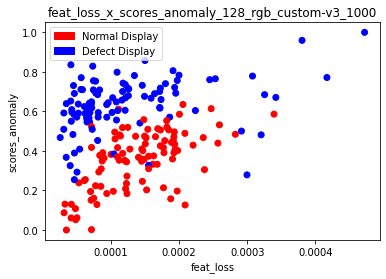

threshold:  [2.         1.         0.63709164 0.63506733 0.61645372 0.61134341
 0.5894961  0.58561354 0.56153636 0.55813919 0.5562929  0.55309885
 0.54107576 0.51271168 0.50933304 0.50929616 0.50924386 0.50596791
 0.50053846 0.48444735 0.48144327 0.47174857 0.46772177 0.46080898
 0.45288179 0.40946491 0.40914594 0.39078064 0.38938458 0.3874491
 0.38496244 0.36808273 0.36779164 0.33262249 0.32564892 0.29384438
 0.27899799 0.25480168 0.25468704 0.        ]


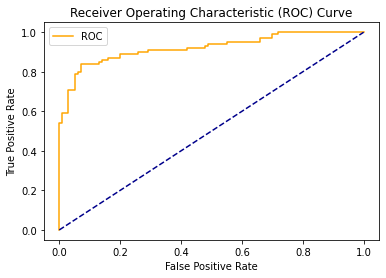

auc:  0.9209
threshold:  0.5410757592680618
Confusion matrix, without normalization
[[93  7]
 [17 83]]


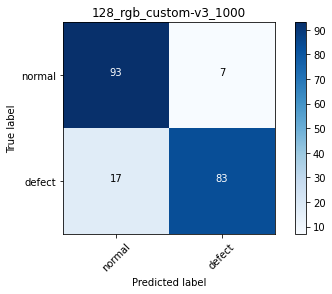

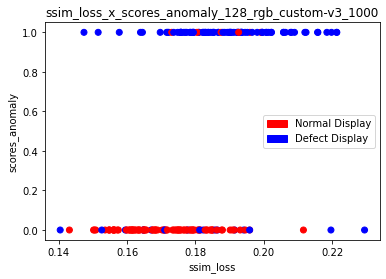

Accuracy:  0.88
False Alarm Rate:  0.07777777777777778
Leakage Rate:  0.15454545454545454
precision_score:  0.9222222222222223
recall_score:  0.83
F1-Score:  0.8736842105263158


<Figure size 432x288 with 0 Axes>

In [17]:

if __name__ == "__main__":
    
    '''
    In Default:
    Clahe: OFF
    BCET: OFF
    Resize: crop or padding (decided by tensorflow)
    Datasets: For trainning dataset, it'll have additional datasets (flip-up-down and flip-right-left)
    '''
    
    # run the function here
    """ Set Hyperparameters """
    
    mode = "custom-v3"
    batch_size = 32
    num_epochs = 1000
    name_model= str(IMG_H)+"_rgb_"+mode+"_"+str(num_epochs)
    
    resume_trainning = False
    lr = 1e-5
    
    print("start: ", name_model)
    
    # set dir of files
    train_images_path = "mura_data/RGB/new_train_data/normal/*.bmp"
    test_data_path = "mura_data/RGB/clahe_test_data_v2"
    saved_model_path = "mura_data/RGB/saved_model/"
    
    logs_path = "mura_data/RGB/logs/"
    
    logs_file = logs_path + "logs_" + name_model + ".csv"
    
    path_gmodal = saved_model_path + name_model + "_g_model" + ".h5"
    path_dmodal = saved_model_path +  name_model + "_d_model" + ".h5"
    
    """
    Create a MirroredStrategy object. 
    This will handle distribution and provide a context manager (MirroredStrategy.scope) 
    to build your model inside.
    """
    
    strategy = tf.distribute.MirroredStrategy()
    
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    input_shape = (IMG_H, IMG_W, IMG_C)
    # print(input_shape)
    
    ## init models ##
    
    # set input 
    inputs = tf.keras.layers.Input(input_shape, name="input_1")
    
    g_model = build_generator_resnet50_unet(inputs)
    
    d_model = build_discriminator(inputs)
    
#     d_model.summary()
#     g_model.summary()
    
    resunetgan = ResUnetGAN(g_model, d_model)
    
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.999)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.999)
    
    resunetgan.compile(g_optimizer, d_optimizer, logs_file, resume_trainning)
    
#     print(train_images_dataset)
    """ run trainning process """
#     train_images = glob(train_images_path)
#     train_images_dataset = load_image_train(train_images, batch_size)
#     train_images_dataset = train_images_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#     size_of_dataset = len(list(train_images_dataset)) * batch_size
    
#     steps = int(size_of_dataset/batch_size)
#     run_trainning(resunetgan, train_images_dataset, num_epochs, path_gmodal, path_dmodal, logs_path, logs_file, name_model, steps,resume=resume_trainning)
    
#     """ run testing """
    resunetgan.testing(test_data_path, path_gmodal, path_dmodal, name_model)
    # resunetgan.checking_gen_disc(mode, path_gmodal, path_dmodal, test_data_path)